<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 8

### **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

In [1]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy.linalg as la
%matplotlib inline

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


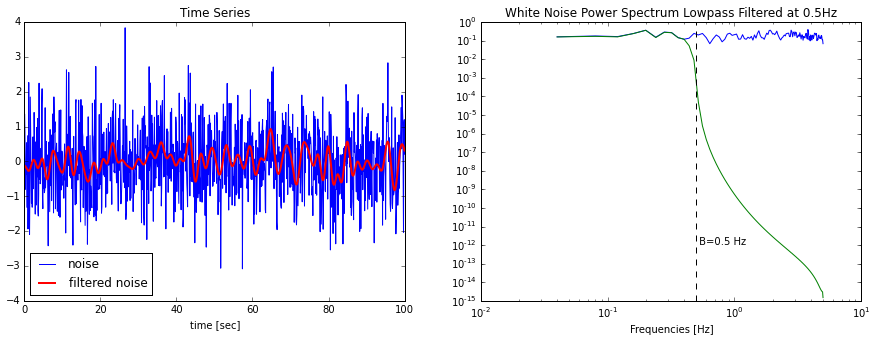

In [2]:
N = 1000
x = random.randn(N)
dt = 0.1
t = np.linspace(0, 100, 1000)

B = 0.5
fs = 1./dt
fny = fs/2
nfft = 250
args = {'NFFT':nfft,'Fs':fs,'noverlap':nfft/2.,'window':mlab.window_hanning}

#lowpass ellip filter
wp = 0.9*B/fny
ws = B/fny
N, wn = signal.ellipord(wp, ws, 0.1, 80)
b,a = signal.ellip(N, 0.1, 80, wn, output='ba', btype='lowpass')
xf = signal.filtfilt(b, a, x)

Gxx, f = mlab.psd(x, **args)
Gxxf, f = mlab.psd(xf, **args)

ax = plt.subplots(1,2, figsize=(15,5))
ax1 = plt.subplot(1,2,2)
ax1.loglog(f, Gxx, label='')
ax1.loglog(f, Gxxf)
ax1.set_title('White Noise Power Spectrum Lowpass Filtered at 0.5Hz')
ax1.set_xlabel('Frequencies [Hz]')
ax1.axvline(x=B,linestyle='--',color='k');ax1.text(B,1e-12,' B=%.1f Hz' %B)
ax1.legend(loc=3)

ax2 = plt.subplot(1,2,1)
ax2.plot(t, x, label='noise')
ax2.plot(t, xf, 'r', linewidth=2, label='filtered noise')
ax2.set_xlabel('time [sec]')
ax2.legend(loc=3)
ax2.set_title('Time Series')

Looks like everything is functioning properly. Lovely.

<div style='background:#F0F0F0'>**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz.  Show that you can recover the 10 Hz time series using the Sampling Theorem.</div>

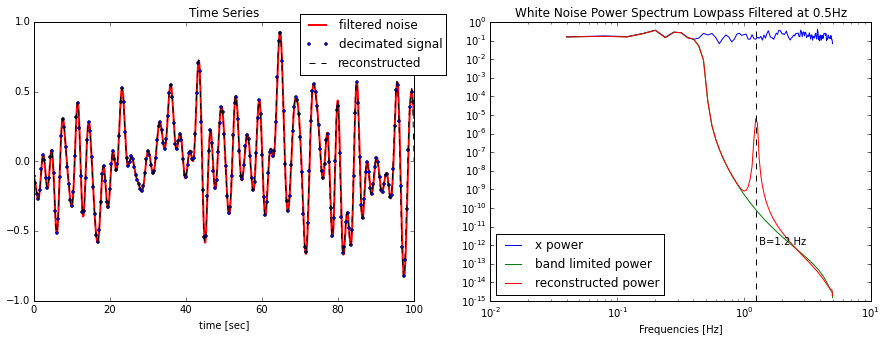

In [3]:
dec = 4
tdec = t[::dec]
xdec = xf[::dec]
dtdec = dt*dec
fs = 1./dtdec
N = len(xdec)
B = 1.25

n = np.arange(N)
    # reconstruct the full time series just from the subsampled data xn:  
xreco=1.*xf # trim the last N*25 data points...

for i in range(len(xreco)):
    xreco[i] = np.sum(xdec*np.sinc(2*B*t[i]-n))

Gxxr, ff = mlab.psd(xreco, **args)

ax = plt.subplots(1,2, figsize=(15,5))
ax1 = plt.subplot(1,2,2)
ax1.loglog(f, Gxx, label='x power')
ax1.loglog(f, Gxxf, label='band limited power')
ax1.loglog(ff, Gxxr, label='reconstructed power')
ax1.set_title('White Noise Power Spectrum Lowpass Filtered at 0.5Hz')
ax1.set_xlabel('Frequencies [Hz]')
ax1.axvline(x=B,linestyle='--',color='k');ax1.text(B,1e-12,' B=%.1f Hz' %B)
ax1.legend(loc=3)

ax2 = plt.subplot(1,2,1)
ax2.plot(t, xf, 'r', linewidth=2, label='filtered noise')
ax2.plot(tdec, xdec, 'o', markersize=3, label='decimated signal')
ax2.plot(t, xreco, 'k--', label='reconstructed')
ax2.set_xlabel('time [sec]')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.set_title('Time Series')

made a real nice reconstruction of the plot

<div style='background:#F0F0F0'>**3** Now decimate by a factor of 40 to get a time series sampled at 0.25 Hz.  Show that you cannot recover the 10 Hz time series using the Sampling Theorem.</div>

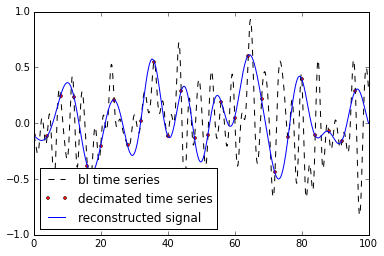

In [4]:
dec = 40
tdec = t[::dec]
xdec = xf[::dec]
dtdec = dt*dec
fs = 1./dtdec
N = len(xdec)
B = 0.125

plt.plot(t, xf, 'k--', label='bl time series')
plt.plot(tdec, xdec, 'ro', markersize=3, label='decimated time series')

n = np.arange(N)
    # reconstruct the full time series just from the subsampled data xn:  
xreco=1.*xf[:N*dec] # trim the last N*25 data points...
for i in range(N*dec):
    xreco[i] = np.sum(xdec[:N]*np.sinc(2*B*t[i]-n))
plt.xlim([0,100])
plt.plot(t, xreco, label='reconstructed signal')
plt.legend(loc=3)

Reconstruction totally failed.

## Q2: Cubic Spline

Using the data below...

In [5]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x = np.cos(t*2*np.pi/3)

**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

[[ 1.   0.   0.   0.   0.   0.   0. ]
 [ 2.5  5.4  0.2  0.   0.   0.   0. ]
 [ 0.   0.2  1.8  0.7  0.   0.   0. ]
 [ 0.   0.   0.7  3.   0.8  0.   0. ]
 [ 0.   0.   0.   0.8  6.2  2.3  0. ]
 [ 0.   0.   0.   0.   2.3  9.6  2.5]
 [ 0.   0.   0.   0.   0.   0.   1. ]]


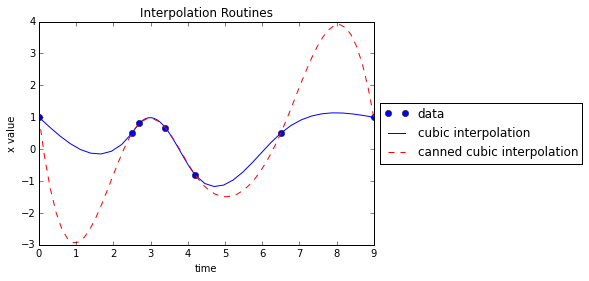

In [11]:
from scipy.interpolate import interp1d

t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x = np.cos(t*2*np.pi/3)

func = interp1d(t, x, kind='cubic')
t1 = np.linspace(np.min(t), np.max(t), 60)
xcanned = func(t1)

N = len(t) - 1
A = np.zeros((N+1, N+1))
dt = np.diff(t)
dx = np.diff(x)
dxt = np.zeros(N+1)

for i in range(0, N+1):
    if(i==0): 
        A[i][i] = 1.
        #A[i][i+1] = dt[i]
    elif(i==N):
        A[i][i] =1.
        #A[i][i-1] = dt[i-1]
    else:
        A[i][i-1] = dt[i-1]
        A[i][i] = 2.*(dt[i] + dt[i-1])
        A[i][i+1] = dt[i]
        dxt[i] = (dx[i]/dt[i]) - (dx[i-1]/dt[i-1])

print A
        
Ainv = la.inv(A)
c = np.dot(Ainv, 3.*dxt)

d = c*0.
b = c*0.
d[N-1] = (-2.*c[N-1])/(dt[N-1]*6.)
for i in range(0, N-1):
    d[i] = (c[i+1] - c[i])/(3.*dt[i])
for i in range(0, N):    
    b[i] = (dx[i] - c[i]*dt[i]**2 - d[i]*dt[i]**3)/dt[i]

G = np.column_stack((x, b, c, d))

Tt = np.zeros(10)
tact = []
for i in range(0, 6):
    tacty = np.linspace(t[i], t[i+1], 10)
    tv = tacty - t[i]
    tact = np.append(tact, tacty)
    Tt = np.vstack([Tt, tv])
tact.flatten()
Tt = Tt[1:,:]

one = np.ones(10)
#Tt = np.column_stack((one, tv, tv**2, tv**3))

xact = []
for i in range(0, G.shape[0]-1):
    tt = np.column_stack((one, Tt[i], Tt[i]**2, Tt[i]**3))
    xacty = np.dot(G[i], tt.T)
    xact = np.append(xact, xacty)
xact.flatten()

plt.plot(t, x, 'o', label='data')
plt.plot(tact, xact, 'b', label='cubic interpolation')
plt.plot(t1, xcanned, 'r--', label='canned cubic interpolation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('time')
plt.ylabel('x value')
plt.title('Interpolation Routines')

so smooth. The cubic spline made from the matrix is more conservative on the amplitude than the canned routine cubic. Neither interpolation methods reconstruct the cosine function, maybe if more terms were added it could do that, like a pentubic spline or hexubic, or something. Looks pretty nice though. Where the point density is greatest, both interpolation methods nailed it.